In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np
from scipy import linalg
from scipy import stats

import matplotlib.pyplot as plt

import mahalanobis as maha

Data, in the form of a table, are stored as a `.parquet` file compressed with `gzip`. Can be read with `pandas`.

In [4]:
df = pd.read_parquet("data/Covid-Combo.parquet.gzip")

In [5]:
# Metadata columns: non-morphological features

meta_cols = {
    'type', # {'treated', 'infected', 'uninfected'}, i.e., drug (either combination or single control), DMSO, and healthy, respectively
    'batch_id', # unique identifier of the first drug in the given combination (find the corresponding compound name in 'id_to_name.txt')
    'pair_batch_id', # id of the second drug. If not a combination (single control, uninfected, or DMSO), then `pair_batch_id`='single'
    'conc', # concentration of the first drug in the given combination, in micromoles
    'pair_conc',    # concentration of the second drug. If not a combination, then `pair_conc`=-1
}

In [6]:
# Omit 'uninfected' from the set for predictions
df_cells = df[df['type'] != 'uninfected']
x_cells = df_cells.drop(
    columns=set(meta_cols).intersection(df.columns)
).copy()

In [7]:
df_control = df[df['type'].isin(['uninfected', 'infected'])].copy()
df_control.reset_index(inplace=True, drop=True)

X = df_control.drop(
    columns=set(meta_cols).intersection(df_control.columns)
).copy()

y = np.where(df_control['type'] == 'infected', 0, 1)

#### Whitening and Mahalanobis distance

In [8]:
# There are some methods in literature that allow to automatically select the optimal number of components from PCA
# We test one such method below: 'svht' from mahalanobis.py

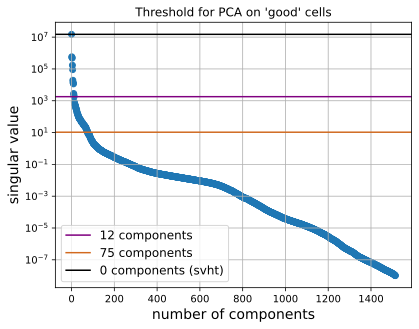

In [9]:
df_good = df[df['type'] == 'uninfected'].copy()
# morphological profile of uninfected cells ('good')
x_good = df_good.drop(
    columns=set(meta_cols).intersection(df.columns)
).to_numpy()

cov_matrix = np.cov(x_good, rowvar=False)
sigma, u = linalg.eigh(cov_matrix, check_finite=True)
rank = min(*x_good.shape) - 1
sigma = sigma[::-1]
# remove values under ~float precision
too_low = len(sigma[sigma>1e-8])
rank = min(rank, too_low)

plt.scatter(range(rank), sigma[:rank])

# manual threshold = 10^3
thresh = sigma[sigma >= 10**3][-1]
n_comp = int(np.where(sigma == thresh)[0][0])
plt.axhline(thresh, c='purple', label=f'{n_comp} components')

# manual threshold = 10
thresh = sigma[sigma >= 10][-1]
n_comp = int(np.where(sigma == thresh)[0][0])
plt.axhline(thresh, c='chocolate', label=f'{n_comp} components')

# optimal threshold for the PCA of 'good' cells
thresh = int(maha.svht(x_good))
plt.axhline(sigma[thresh], c='k', label=f'{thresh} components (svht)')

plt.grid()
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('number of components', fontsize=14)
plt.ylabel('singular value', fontsize=14)
plt.title("Threshold for PCA on 'good' cells")
plt.show()

In [10]:
n_components = 18  # we use a number of components sufficient to make uninfected and infected cells distinguishable
df_good = df[df['type'] == 'uninfected'].copy()
x_good = df_good.drop(
    columns=set(meta_cols).intersection(df.columns)
).copy()

dist_pred = maha.get_distance(x_good, x_cells, n_components=n_components)
df_dist = pd.DataFrame(dist_pred, columns=['distance'])

proba_pred = maha.get_proba(x_good, x_cells, n_components=n_components)
df_proba = pd.DataFrame(proba_pred, columns=['proba'])

#### Concatenate predictions


In [11]:
predictions = pd.concat(
    [
        df_cells[
            ['type', 'batch_id', 'pair_batch_id', 'conc', 'pair_conc']
        ].reset_index(drop=True),
        df_dist,
        df_proba,
    ], 
    axis=1,
)

predictions.head()

type   batch_id pair_batch_id  conc  pair_conc   distance     proba
0  treated  BJ1897713     BJ1894563  0.83       0.83   5.632891  0.023665
1  treated  BJ1897713     BJ1894563  0.83       0.83   4.126773  0.521026
2  treated  BJ1897713     BJ1894563  0.83       0.83   6.782581  0.000296
3  treated  BJ1897713     BJ1894563  0.83       0.83  11.371209  0.000000
4  treated  BJ1897713     BJ1894563  0.83       0.83   6.996991  0.000108

#### Ranking all compounds by distance

Rows in the ranking below correspond to different compounds at different concentrations, i.e., we average over replicates.

In [12]:
def quantile(n):
    def quantile_(x):
        return x.quantile(n)
    quantile_.__name__ = f'q_{n*100:.0f}'
    return quantile_

selected_columns = predictions[[
    'type',
    'batch_id',
    'pair_batch_id',
    'conc',
    'pair_conc',
    'distance',
    'proba',
]].copy()

# Aggregate replicates
average_predictions = selected_columns.groupby(
    by=['type', 'batch_id', 'pair_batch_id', 'conc', 'pair_conc'], 
    as_index=False
).agg({
        'distance': [quantile(.25), quantile(.75), 'median'],
        'proba': [quantile(.25), quantile(.75), 'median'],
})

# Rename columns
custom_columns = [''.join(col) for col in average_predictions.columns.to_flat_index() if not col[1]]
custom_columns += ['_'.join(col) for col in average_predictions.columns.to_flat_index() if col[1]]
average_predictions.columns = custom_columns

# Sort by distance to non-infected
average_predictions.sort_values(by=['distance_median'], ascending=True, inplace=True)

# Quantiles are written as plus/minus to the median
average_predictions['distance_q_75'] = average_predictions['distance_q_75'] - average_predictions['distance_median']
average_predictions['distance_q_25'] =  average_predictions['distance_median'] - average_predictions['distance_q_25']
average_predictions['proba_q_75'] = average_predictions['proba_q_75'] - average_predictions['proba_median']
average_predictions['proba_q_25'] =  average_predictions['proba_median'] - average_predictions['proba_q_25']

average_predictions.reset_index(inplace=True, drop=True)
average_predictions.to_csv("output/Covid_combo_ranked.csv", sep=';', index=False)
average_predictions.head(5)

type   batch_id pair_batch_id   conc  pair_conc  distance_q_25  \
0  treated  BJ1898404     BJ1895608   3.33       0.83       0.145968   
1  treated  BJ1898163     BJ1895296   3.33       0.17       0.322831   
2  treated  BJ1895621     BJ1894069   3.33       3.33       0.162741   
3  treated  BJ1897887     BJ1898949  10.00       0.83       0.180093   
4  treated  BJ1898414     BJ1895591   3.33       0.33       0.288564   

   distance_q_75  distance_median  proba_q_25  proba_q_75  proba_median  
0       0.546275         3.372166    0.240411    0.039827      0.877932  
1       1.185026         3.519109    0.600472    0.097836      0.826785  
2       0.865805         3.539127    0.451573    0.057659      0.818960  
3       1.068914         3.618511    0.552749    0.070272      0.785981  
4       2.256972         3.650820    0.761976    0.109278      0.771701

#### Visualization

In [13]:
# For convinience of visualisation, duplicate each row corresponding to a drug combination and swap 'batch_id'<->'pair_batch_id', 'conc'<->'pair_conc'
combos = (average_predictions['type'] == 'treated') & (average_predictions['pair_batch_id'] != 'single')
df_combos = average_predictions[combos].copy()
average_predictions.drop(df_combos.index, inplace=True)
average_predictions.reset_index()
df_combos_duplicates = df_combos.rename(
    columns={
        'batch_id': 'pair_batch_id',
        'pair_batch_id': 'batch_id',
        'conc': 'pair_conc',
        'pair_conc': 'conc'
    }
)
new_average_predictions = pd.concat([average_predictions, df_combos, df_combos_duplicates], ignore_index=True)
new_average_predictions.sort_values(by=['distance_median'], ascending=True, inplace=True, ignore_index=True)

# And enumerate each combination with 'combo_id'
combos = (new_average_predictions['type'] == 'treated') & (new_average_predictions['pair_batch_id'] != 'single')
df_combos = new_average_predictions[combos].copy()
df_combos['ids_in_combo'] = df_combos.apply(
    lambda x: frozenset([x['batch_id'], x['pair_batch_id']]),
    axis=1
)
combinations = set(df_combos['ids_in_combo'])
# dict for mapping
mapping = {pair: count for count, pair in enumerate(combinations)}
df_combos['combo_id'] = df_combos['ids_in_combo'].map(mapping).astype('int')
new_average_predictions['combo_id'] = -1
new_average_predictions.loc[combos, 'combo_id'] = df_combos['combo_id']

average_predictions = new_average_predictions.copy()
average_predictions.head()

type   batch_id pair_batch_id  conc  pair_conc  distance_q_25  \
0  treated  BJ1895608     BJ1898404  0.83       3.33       0.145968   
1  treated  BJ1898404     BJ1895608  3.33       0.83       0.145968   
2  treated  BJ1898163     BJ1895296  3.33       0.17       0.322831   
3  treated  BJ1895296     BJ1898163  0.17       3.33       0.322831   
4  treated  BJ1895621     BJ1894069  3.33       3.33       0.162741   

   distance_q_75  distance_median  proba_q_25  proba_q_75  proba_median  \
0       0.546275         3.372166    0.240411    0.039827      0.877932   
1       0.546275         3.372166    0.240411    0.039827      0.877932   
2       1.185026         3.519109    0.600472    0.097836      0.826785   
3       1.185026         3.519109    0.600472    0.097836      0.826785   
4       0.865805         3.539127    0.451573    0.057659      0.818960   

   combo_id  
0       187  
1       187  
2       338  
3       338  
4       203

In [14]:
def plot_compounds_separately(compounds, negative=None, n_components=None, metric='distance'):

    if n_components is None:
        raise ValueError("Please, specify the number of components used in Mahalanobis distance computation")

    y_metric = f"{metric}_median"
    y_metric_q_25 = f"{metric}_q_25"
    y_metric_q_75 = f"{metric}_q_75"

    drugs = compounds[compounds['type'] == 'treated']

    conf_intervals = [0.5, 0.75]
    healthy_left = dict()
    healthy_right = dict()
    for conf in conf_intervals:
        if metric == 'distance':
            left_sq, right_sq = stats.chi2.interval(confidence=conf, df=n_components)
            healthy_left[conf], healthy_right[conf] = np.sqrt(left_sq), np.sqrt(right_sq)        
        elif metric == 'proba':
            healthy_left[conf],  healthy_right[conf] = conf, 1
        
    if negative is not None:
        # neg_median = negative[y_metric].iloc[0]
        neg_left = negative[y_metric].iloc[0] - negative[y_metric_q_25].iloc[0]
        neg_right = negative[y_metric].iloc[0] + negative[y_metric_q_75].iloc[0]

    if metric == 'distance':
        if negative is None:
            ymin, ymax = min(healthy_left.values()), 3*max(healthy_right.values())
        else:
            ymin, ymax = min(healthy_left.values()), neg_right + 1
    elif metric == 'proba':
        ymin, ymax = 0, 1

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    batch_ids = drugs['batch_id'].unique()
    cols = 4
    rows = len(batch_ids) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    fig.tight_layout()

    # Iterate over compounds
    for r in range(rows):
        for c in range(cols):
            i = r * 4 + c
            batch_id = batch_ids[i]
            combo_ids = drugs[drugs['batch_id'] == batch_id]['combo_id'].unique()
            drug_concentrations = set()
            for j, combo_id in enumerate(combo_ids):
                compound = drugs[(drugs['batch_id'] == batch_id) & (drugs['combo_id'] == combo_id)]
                pair_conc = np.sort(compound['pair_conc'].unique())
                for k, p_conc in enumerate(pair_conc):
                    selected = compound[compound['pair_conc'] == p_conc]
                    sort_arg = np.argsort(selected['conc'])
                    conc = selected['conc'].to_numpy()[sort_arg]
                    y_values = selected[y_metric].to_numpy()[sort_arg]
                    y_perc_25 = selected[y_metric_q_25].to_numpy()[sort_arg]
                    y_perc_75 = selected[y_metric_q_75].to_numpy()[sort_arg]
                    linestyle = '-' if k == 0 else '--'
                    axs[r, c].errorbar(
                        conc, y_values, yerr=[y_perc_25, y_perc_75], 
                        capsize=2, elinewidth=1.5, ls=linestyle, c=colors[j % len(colors)],
                        label=(selected['pair_name'] + f' at {p_conc}')
                    )
                drug_concentrations = drug_concentrations.union(set(conc))

            x_ticks = list(drug_concentrations)
            
            # Uninfected cells - confidence intervals
            for i, conf in enumerate(conf_intervals):
                label = "Non-infected" if i == 0 else None
                axs[r, c].fill_between(x_ticks, healthy_left[conf], healthy_right[conf], 
                                color='royalblue', alpha=0.5*(1-conf)**0.5, 
                                zorder=1, label=label
                    )
            axs[r, c].text(
                (x_ticks[0]+x_ticks[-1])/2, (healthy_left[conf]+healthy_right[conf])/2, 
                'Non-infected', ha='center', va='center', alpha=0.4
            )
            
            if negative is not None:
                # Negative state (DMSO)
                axs[r, c].fill_between(
                    x_ticks, neg_left, neg_right, 
                    color='k', alpha=0.25, zorder=1,
                )
                axs[r, c].text(
                    (x_ticks[0]+x_ticks[-1])/2, (neg_left+neg_right)/2,
                    'DMSO', ha='center', va='center', alpha=0.4,
                )

            axs[r, c].set_title(compound['name'].iloc[0])
            axs[r, c].set_xticks(x_ticks)
            # axs[r, c].set_xscale('log')
            axs[r, c].set_ylim(ymin, ymax)
            if c == 0:
                axs[r, c].set_ylabel(f'{metric}')
            if r == rows - 1:
                axs[r, c].set_xlabel('concentration')

    fig.savefig(f"output/Covid-combo-{metric}.png", dpi=300, bbox_inches="tight")

In [15]:
compounds = average_predictions.copy()

negative = compounds[compounds['type'] == 'infected'].copy()    # infected & non-treated
compounds = compounds[compounds['type'] == 'treated']

In [16]:
# If we want to use batch_id's as compound identifiers
compounds['name'] = compounds['batch_id']
compounds['pair_name'] = compounds['pair_batch_id']

In [17]:
# If we want to use compound names instead of batch_id's
with open("data/id_to_name.txt", 'r') as file:
    table = file.readlines()
id_to_name = {}
for i, line in enumerate(table):
    id_, name = line.rstrip().split('\t')
    id_to_name[id_] = name

def fill_missing_name(batch_id):
    if batch_id in id_to_name:
        return id_to_name[batch_id]
    else:
        return f"Batch_id: {batch_id}"

compounds['name'] = compounds['batch_id'].map(fill_missing_name)
compounds['pair_name'] = compounds['pair_batch_id'].map(fill_missing_name)

In [18]:
plot_compounds_separately(compounds, negative, n_components)

In [19]:
# plot_compounds_separately(compounds, negative, n_components, metric='proba')

In [20]:
# # Run this cell to install the library for interactive graphs

# !pip3 install plotly
# !pip3 install --upgrade nbformat

In [21]:
import plotly.express as px


def plot_one_compound(compounds, batch_id, negative=None, n_components=None, metric='distance'):

    if n_components is None:
        raise ValueError("Please, specify the number of components used in Mahalanobis distance computation")

    y_metric = f"{metric}_median"
    y_metric_q_25 = f"{metric}_q_25"
    y_metric_q_75 = f"{metric}_q_75"

    compound = compounds[compounds['batch_id'] == batch_id].copy()
    grouped = compound.groupby(by='pair_name').agg({'pair_conc': 'min'})
    # Use solid line for one concentration of the second drug
    # and dashed line for another concentration
    compound['line_dash'] = compound.apply(
        lambda x: 
            'solid' if (x['pair_conc'] == grouped.loc[x['pair_name'], 'pair_conc']) 
            else 'dash', 
        axis=1
    )
    compound['line_name'] = compound.apply(
        lambda x: x['pair_name']+' at '+str(x['pair_conc']),
        axis=1
    )
    line_dash_map = pd.Series(
        compound['line_dash'].values, index=compound['line_name']
    ).to_dict()

    fig = px.line(
        compound.sort_values(by='conc'), x='conc', y=y_metric,
        color='pair_name', line_dash='line_name', line_dash_map=line_dash_map,
        width=800, height=400, markers=True, 
        error_y=y_metric_q_75, error_y_minus=y_metric_q_25,
    )
    # update labels for the legend
    def crop_name(name):
        new_name = name.split(', ')[-1]
        return new_name
    fig.for_each_trace(lambda t: t.update(
            name=crop_name(t.name),
            legendgroup=crop_name(t.name),
            hovertemplate=t.hovertemplate.replace(t.name, crop_name(t.name))
        )
    )

    # Healthy cells - confidence intervals
    for i, conf in enumerate([0.5, 0.75]):
        label = dict(
            text="Uninfected", font=dict(size=15, color="black"), textposition="middle left"
        ) if i == 0 else None

        if metric == 'distance':
            left, right = stats.chi2.interval(confidence=conf, df=n_components)
            left, right = np.sqrt(left), np.sqrt(right)
            
        elif metric == 'proba':
            left, right = conf, 1

        fig.add_hrect(
            type="rect",
            y0=left, y1=right,
            fillcolor="royalblue", opacity=0.8*(1-conf)**0.5,
            layer="below", line_width=0, label=label
        )

    # Negative state (DMSO)
    if negative is not None:
        conc = range(0, 31, 1)
        median = negative[y_metric].iloc[0]
        neg_left = median - negative[y_metric_q_25].iloc[0]
        neg_right = median + negative[y_metric_q_75].iloc[0]
        fig.add_hrect(
            type="rect",
            y0=neg_left, y1=neg_right,
            fillcolor="grey", opacity=0.25,
            layer="below", line_width=0,
            label=dict(
                text="DMSO", font=dict(size=15, color="black"), textposition="middle left"
            )
        )

    if metric == 'distance':
        if negative is not None:
            ymin, ymax = left, neg_right + 1
        else:
            ymin, ymax = left, max(compound[y_metric]+compound[y_metric_q_75])
    elif metric == 'proba':
        ymin, ymax = 0, 1

    conc = np.unique(compounds['conc'])
    fig.update_xaxes(title_text="concentration", gridcolor='lightgrey', type="log", tickvals=conc)
    if metric == 'distance':
        # fig.update_yaxes(title_text='distance', gridcolor='lightgrey', type="log", tickvals=[1, 5, 10, 100], range=[ymin, ymax])
        fig.update_yaxes(title_text='distance', gridcolor='lightgrey', range=[ymin, ymax])
    elif metric == 'proba':
        fig.update_yaxes(title_text='probability', gridcolor='lightgrey', tickvals=[1, 5, 10, 100])

    fig.update_layout(
        title_text=compound['name'].iloc[0],
        plot_bgcolor='white',
        legend_title="Pair",
    )

    fig.show()

In [22]:
sel_batch_id = 'BJ1895013'  # 'BJ1895608'
# sel_batch_id = 'DO8167002'    # anti-viral

plot_one_compound(compounds, batch_id=sel_batch_id, negative=negative, n_components=n_components)

In [23]:
plot_one_compound(compounds, batch_id=sel_batch_id, negative=negative, n_components=n_components, metric='proba')